In [1]:
# !pip install graphviz

In [ ]:
# imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score

from sklearn.pipeline import Pipeline, TransformerMixin
from sklearn.base import BaseEstimator

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

# from graphviz import Source
# from sklearn import tree

In [7]:
file_name = "BPL.csv"
df = pd.read_csv(file_name)
df.head(5)

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [8]:
# there are no nulls there
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
ID                    5000 non-null int64
Age                   5000 non-null int64
Experience            5000 non-null int64
Income                5000 non-null int64
ZIP Code              5000 non-null int64
Family                5000 non-null int64
CCAvg                 5000 non-null float64
Education             5000 non-null int64
Mortgage              5000 non-null int64
Personal Loan         5000 non-null int64
Securities Account    5000 non-null int64
CD Account            5000 non-null int64
Online                5000 non-null int64
CreditCard            5000 non-null int64
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


In [9]:
# numeric and categorical features
num_cols = ['Age', 'Experience', 'Income', 'CCAvg', 'Mortgage', 'Family', 'Education', 'ZIP Code']
intersection_cols = ['Education', 'Family']
cat_cols = list((set(df.columns) - set(num_cols)).union(set(intersection_cols)))

print('Numeric Columns:', num_cols)
print('Categorical Columns:', cat_cols)
print('Intersection Columns:', intersection_cols)

Numeric Columns: ['Age', 'Experience', 'Income', 'CCAvg', 'Mortgage', 'Family', 'Education', 'ZIP Code']
Categorical Columns: ['CD Account', 'CreditCard', 'ID', 'Education', 'Personal Loan', 'Securities Account', 'Family', 'Online']
Intersection Columns: ['Education', 'Family']


In [10]:
# negative Experience...
df.describe()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,2500.500000,45.338400,20.104600,73.774200,93152.503000,2.396400,1.937938,1.881000,56.498800,0.096000,0.104400,0.06040,0.596800,0.294000
std,1443.520003,11.463166,11.467954,46.033729,2121.852197,1.147663,1.747659,0.839869,101.713802,0.294621,0.305809,0.23825,0.490589,0.455637
min,1.000000,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1250.750000,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,2500.500000,45.000000,20.000000,64.000000,93437.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,3750.250000,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,3.000000,101.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,5000.000000,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [11]:
df.describe().loc['min']

ID                       1.0
Age                     23.0
Experience              -3.0
Income                   8.0
ZIP Code              9307.0
Family                   1.0
CCAvg                    0.0
Education                1.0
Mortgage                 0.0
Personal Loan            0.0
Securities Account       0.0
CD Account               0.0
Online                   0.0
CreditCard               0.0
Name: min, dtype: float64

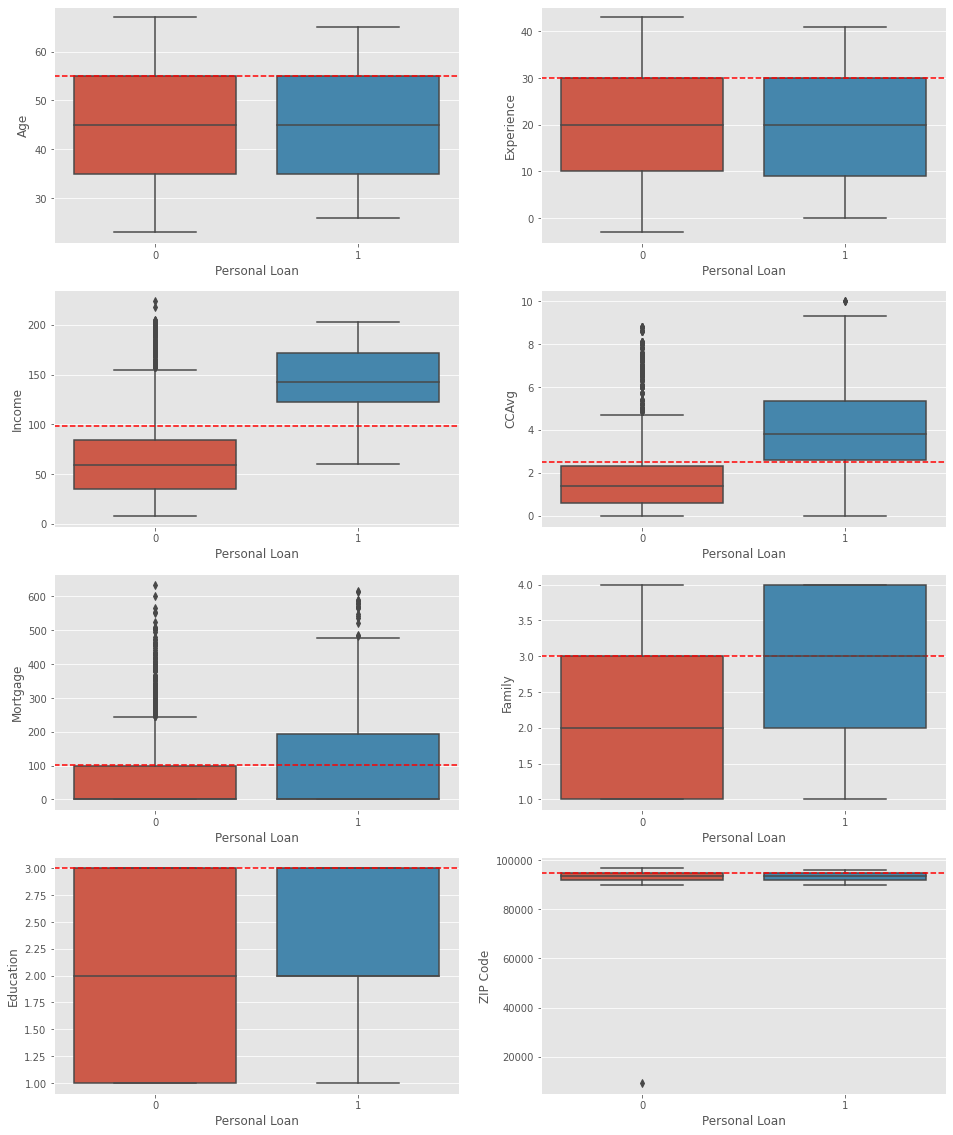

In [12]:
# feature importance
fig, ax = plt.subplots(4, 2, figsize=(16, 20))

for current_column, axis in zip(num_cols, ax.flatten()):
    sns.boxplot(x='Personal Loan', y=current_column, data=df, ax=axis)
    axis.axhline(df.describe().loc['75%', current_column], ls='--', c='red')

In [13]:
# train_test_split
target_col = ['Personal Loan']

X, y = df.drop(target_col, axis=1), df[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [14]:
class FeatureSelector(TransformerMixin, BaseEstimator):
    '''
    Custom Transforemr.
    Drops columns: ID, ZIP Code,'Age, Experience.
    '''

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # transform X via code or additional methods
        # print(X.columns)
        return X.drop(["ID", "ZIP Code", 'Age', 'Experience'], axis=1)
    
    
class FeatureGemerator(TransformerMixin, BaseEstimator):
    '''
    Custom Transforemr.
    Creates several categorical columns
    '''
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # transform X via code or additional methods
        
        # is sth features
        X['IsMortgaged'] = X['Mortgage'] > 0
        X['IsFamily'] = X['Family'] > 1
        X['IsEducated'] = X['Education'] > 1

        # Is > than 75 qq
        X['IsMortgaged75'] = (X['Mortgage'] > X.describe().loc['75%', 'Mortgage']) & X['IsMortgaged']
        X['IsIncome75'] = X['Income'] > X.describe().loc['75%', 'Income']
        X['IsCCAvg75'] = X['CCAvg'] > X.describe().loc['75%', 'CCAvg']
        
        return X
    
def add_layer_to_pipeline(pipeline, layer,
                             pipeline_name='pipe', layer_name='model'):
    new_pipeline = Pipeline([
        (pipeline_name, pipeline),
        (layer_name, layer)
    ])
    
    return new_pipeline

In [15]:
# creating a pipeline to preprocess data in future
data_engeneering_pipeline = Pipeline([
    ('feature_generator', FeatureGemerator()),
    ('feature_selector', FeatureSelector()),
    ('scaler', StandardScaler())
])

# savling pipeline
joblib.dump(data_engeneering_pipeline, 'data_engeneering_pipeline.pkl')

['data_engeneering_pipeline.pkl']

In [16]:
# results of preprocessing
X_train = data_engeneering_pipeline.fit_transform(X_train)
X_test = data_engeneering_pipeline.fit_transform(X_test)

In [17]:
# initializing models, their params and metrics
models = {'RandomForestClassifier': RandomForestClassifier(),
          'LogisticRegression': LogisticRegression(),
          'DecisionTreeClassifier': DecisionTreeClassifier(),
          'KNeighborsClassifier': KNeighborsClassifier(),
          'GradientBoostingClassifier': GradientBoostingClassifier()}

params = {'LogisticRegression': {'C': np.linspace(0.01,2,15),
                                 'penalty': ['l1','l2', 'elasticnet', 'none']},
          'RandomForestClassifier': {'max_features': [1,3,10],
                                      'min_samples_split': [2,3,10],
                                      'min_samples_leaf': [1,3,10],
                                      'bootstrap': [False, True],
                                      'n_estimators': [50, 100, 200, 300],
                                      'n_jobs': [-1]},
          'DecisionTreeClassifier': {'splitter': ['best', 'random'],
                                     'max_depth': ['none'] + [i for i in range(3, 9)]},
          'KNeighborsClassifier':  {'n_neighbors': np.arange(1,50),
                                    'weights': ['uniform', 'distance']},
          'GradientBoostingClassifier': {'learning_rate': [0.001,0.01,0.1,0.05],
                                         'n_estimators': [100,500,1000],
                                         'max_depth': [3,5,10],
                                         'min_samples_split': [2,5,10]}
}

metrics = {'accuracy': accuracy_score,
           'precision': precision_score,
           'recall': recall_score,
           'roc_auc': roc_auc_score, 
           'f1': f1_score}

In [18]:
def train_grdsearch_and_evaluate(X_train, y_train, X_test, y_test, 
                                 models=models, params=params, metrics=metrics, 
                                 n_jobs=-1, verbose=1, scoring='roc_auc', n_splits=5):
    '''
    Returns a matrix (pd.DataFrame) of scores, dict of best_models \
    and dict of their best validation_scores(roc_auc)  
    '''
    
    best_scores={}
    best_estimators={}
    
    df_models = []
    df_training_scores = []
    df_scores = {metric_name:[] for metric_name, _ in metrics.items()}
    
    
    df = pd.DataFrame(columns=['model'] + list(df_scores.values()))

    for model_name, model in models.items():
        search = GridSearchCV(model, param_grid=params[model_name], 
                              cv=StratifiedKFold(n_splits=5), scoring='roc_auc',
                              n_jobs=n_jobs, verbose=verbose).fit(X_train, y_train)
        
        best_scores[model_name] = search.best_score_
        best_estimators[model_name] = search.best_estimator_       
        print(f'Model: {model_name},\nBest score: \
        {best_scores[model_name]}\nBest params: {best_estimators[model_name]}')            
        
        df_models.append(model_name)

        for score_name, score in metrics.items():
            # f1 and accuracy don't work with probas
            # Also RFClassifier don't have predict_proba
            try:
                preds = search.predict_proba(X_test)
                df_scores[score_name].append(score(y_test, preds))
            except Exception as e:
                preds = search.predict(X_test)
                df_scores[score_name].append(score(y_test, preds))
        
    df['model'] = df_models
        
    for score_name, _ in df_scores.items():
        df[score_name] = df_scores[score_name]
            
    return df, best_estimators, best_scores

In [19]:
%%time
scoring_df, best_params, best_scores = train_grdsearch_and_evaluate(X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Model: RandomForestClassifier,
Best score:         0.9970460066913331
Best params: RandomForestClassifier(max_features=10, min_samples_leaf=3,
                       min_samples_split=10, n_estimators=50, n_jobs=-1)
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Model: LogisticRegression,
Best score:         0.9730461536199042
Best params: LogisticRegression(C=2.0)
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Model: DecisionTreeClassifier,
Best score:         0.9941135617477682
Best params: DecisionTreeClassifier(max_depth=3)
Fitting 5 folds for each of 98 candidates, totalling 490 fits
Model: KNeighborsClassifier,
Best score:         0.9810560441922103
Best params: KNeighborsClassifier(n_neighbors=49, weights='distance')
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Model: GradientBoostingClassifier,
Best score:         0.9973699791104739
Best params: GradientBoostingClassif

In [20]:
# save scores to csv
scoring_df.to_csv('scoring_df.csv', index=None)

In [21]:
# validation results
scoring_df = pd.read_csv('scoring_df.csv')
scoring_df

,model,"[0.986, 0.969, 0.978, 0.962, 0.984]","[0.989010989010989, 0.9864864864864865, 0.9879518072289156, 1.0, 0.978021978021978]","[0.8737864077669902, 0.7087378640776699, 0.7961165048543689, 0.6310679611650486, 0.8640776699029126]","[0.9363357902826034, 0.8538115184379432, 0.8975008388262927, 0.8155339805825244, 0.9309240077496725]","[0.9278350515463917, 0.8248587570621468, 0.8817204301075269, 0.7738095238095238, 0.9175257731958761]",accuracy,precision,recall,roc_auc,f1
0,RandomForestClassifier,NaN,NaN,NaN,NaN,NaN,0.986,0.989011,0.873786,0.936336,0.927835
1,LogisticRegression,NaN,NaN,NaN,NaN,NaN,0.969,0.986486,0.708738,0.853812,0.824859
2,DecisionTreeClassifier,NaN,NaN,NaN,NaN,NaN,0.978,0.987952,0.796117,0.897501,0.881720
3,KNeighborsClassifier,NaN,NaN,NaN,NaN,NaN,0.962,1.000000,0.631068,0.815534,0.773810
4,GradientBoostingClassifier,NaN,NaN,NaN,NaN,NaN,0.984,0.978022,0.864078,0.930924,0.917526


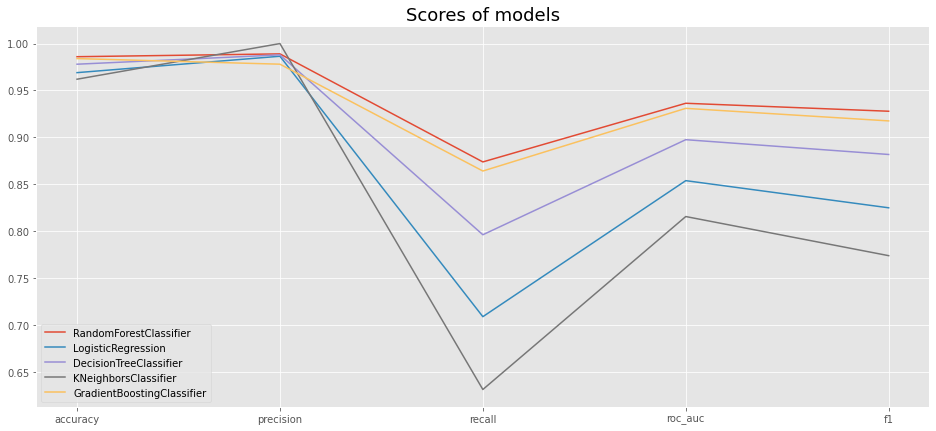

In [22]:
# validation vizualiazation
fig = plt.figure(figsize=(16, 7))
for i in range(len(scoring_df)):
    plt.plot(metrics.keys(), scoring_df.loc[i, metrics.keys()].values, label=scoring_df['model'][i])

plt.title('Scores of models', fontsize=18)
plt.legend();


In [23]:
# final model
final_model = best_params['DecisionTreeClassifier']

#saving model
joblib.dump(final_model, 'final_model.pkl')

# final score
preds = final_model.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, preds)

0.9884350207271271

In [ ]:
# there will be DecisionTree interpretation

# graph = Source( tree.export_graphviz(dtreg, out_file=None, feature_names=X.columns))
# graph.format = 'png'
# graph.render('dtree_render',view=True)